In [9]:
import os
import numpy as np
import tensorflow as tf
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data,wb
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,10,self.T,1))
        xn=np.reshape(xn,(-1,10,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(10,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(10,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

In [3]:
rnn=tf.compat.v1.nn.rnn_cell
class base_LSTMCell(rnn.BasicLSTMCell):
    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.variable_scope(scope or type(self).__name__):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            concat = tf.layers.dense(tf.concat([inputs, h],axis=1), 4 * self._num_units)

            # i = input_gate, j = new_input, f = forget_gate, o = output_gate
            i, j, f, o = tf.split(concat, 4, 1)

            new_c = (c * tf.sigmoid(f + self._forget_bias) + tf.sigmoid(i) *
                    self._activation(j))
            new_h = self._activation(new_c) * tf.sigmoid(o)

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state

class MI_LSTMCell(rnn.BasicLSTMCell):
    """
    Multi-Input LSTM proposed in the paper, Stock Price Prediction Using Attention-based Multi-Input LSTM.
    """
    def __init__(self,
               num_units,
               num_inputs,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs):
        """
        Initialize the basic LSTM cell.
        args:
            num_inputs: MI-LSTM의 입력의 개수. 
                이 파라미터에 따라 입력 게이트의 어텐션 레이어를 설정.
                최소 1개이상.
                1개일 경우, 어텐션 레이어를 제외하고 기본 LSTM과 동일.
        """        
        super(MI_LSTMCell,self).__init__(num_units,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs)
        
        if(type(num_inputs) is not int):
            raise ValueError("num_inputs should be integer")
        if(num_inputs < 1):
            raise ValueError("num_inputs should not be less than 0")
        self.num_inputs = num_inputs
        self.alpha_weight=self.add_variable('alpha_weight',shape=[self._num_units,self._num_units])
        self.alpha_bias=[]
        for i in range(self.num_inputs):
            self.alpha_bias.append(self.add_variable('alpha_bias'+str(i),shape=[1],initializer=tf.zeros_initializer()))

    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.compat.v1.variable_scope(scope or type(self).__name__ ):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            inputs_list = tf.split(inputs,self.num_inputs,1)
            concat = tf.compat.v1.layers.dense(tf.concat([inputs_list[0], h],axis=1), (3+self.num_inputs) * self._num_units)
                                 
            # 0 = forget_gate, 1 = output_gate, 2= main_new_input, 3 = main_input_gate, 4~ = input_gate_for_auxiliary
            main_list = tf.split(concat, 3+self.num_inputs, 1)
                        
            #new_input_gate= list of all new_input.
            new_input_gate=[tf.tanh(main_list[2])]
            #linear layer for auxiliary inputs.
            for i in range(1,self.num_inputs):
                new_input_gate.append(tf.compat.v1.layers.dense(tf.concat([inputs_list[i], h],axis=1),self._num_units,activation=tf.tanh))

            #making list of l. l = sigmoid(input_gate) * tanh(new_input)
            new_l=[]
            for i,new_input in enumerate(new_input_gate,3):
                new_l.append(tf.sigmoid(main_list[i]) * new_input)


            #making list of u.            
            u=[]
            for i,l in enumerate(new_l):
                #temp = transpos(l) X W X Cell_State.
                temp1=tf.matmul(l,self.alpha_weight)
                temp1=tf.expand_dims(temp1,1)
                temp2=tf.matmul(temp1,tf.expand_dims(c,2))
                u.append(tf.tanh(tf.squeeze(temp2+self.alpha_bias[i],axis=2)))

            #making list of alpha.
            alpha=tf.nn.softmax(u,axis=0)

            #making L.
            L=[]
            for i,l in enumerate(new_l):
                L.append(alpha[i]*l)
            L=tf.reduce_sum(L,axis=0)


            #new state = c(t-1) * f + L. new h = tanh(c) + sigmoid(o)
            new_c = (c * tf.sigmoid(main_list[0] + self._forget_bias)+L)
            new_h = self._activation(new_c) * tf.sigmoid(main_list[1])

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state



In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras


class Attention(keras.Model):
    def __init__(self, input_dim, var_scope, reuse=True):
        super(Attention, self).__init__()
        self.input_dim = input_dim
        with tf.compat.v1.variable_scope(var_scope, reuse=reuse):
            self.attention_w = layers.Dense(self.input_dim, name='W')
            self.attention_u = layers.Dense(self.input_dim, name='U')
            self.attention_v = layers.Dense(1, name='V')

    def call(self, input_x, prev_state_tuple):
        """
        Compute the attention weight for input series
        hidden_state, cell_state (batch_size, hidden_dim)
        input_x (batch_size, num_series, input_dim),
        input_dim = num_steps for input attention
        """
        prev_hidden_state, prev_cell_state = prev_state_tuple

        # (batch_size, 1, hidden_dim * 2)
        concat_state = tf.expand_dims(tf.concat([prev_hidden_state, prev_cell_state], axis=-1),
                                      axis=1)

        # (batch_size, num_series, input_dim)
        score_ = self.attention_w(concat_state) + self.attention_u(input_x)

        # (batch_size, num_series, 1)
        # Equation (8)
        score = self.attention_v(tf.nn.tanh(score_))

        # (batch_size, num_series)
        # Equation (9)
        weight = tf.squeeze(tf.nn.softmax(score, axis=1), axis=-1)

        return weight


class LSTMCell(keras.Model):
    def __init__(self, hidden_dim):
        super(LSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_fc = layers.Dense(self.hidden_dim)

    def call(self, input_x, prev_state_tuple):
        """ Return next step's hidden state and cell state  """
        hidden_state, cell_state = prev_state_tuple

        # (batch_size, hidden_dim + input_dim)
        concat_input = tf.concat([hidden_state, input_x], axis=-1)

        # (batch_size * 4, hidden_dim + input_dim)
        concat_input_tiled = tf.tile(concat_input, [4, 1])

        # Equation (3) - (6) without activation
        forget_, input_, output_, cell_bar = tf.split(self.layer_fc(concat_input_tiled),
                                                      axis=0,
                                                      num_or_size_splits=4)

        # (batch_size, hidden_dim)
        # Equation (6)
        cell_state = tf.nn.sigmoid(forget_) * cell_state + \
                     tf.nn.sigmoid(input_) * tf.nn.tanh(cell_bar)

        # Equation (7)
        hidden_state = tf.nn.sigmoid(output_) * tf.nn.tanh(cell_state)
        return (hidden_state, cell_state)


class Encoder(keras.Model):
    def __init__(self, encoder_dim, num_steps):
        super(Encoder, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_layer = Attention(num_steps, var_scope='input_attention')
        self.lstm_cell = LSTMCell(encoder_dim)

    def call(self, inputs):
        """
        inputs: (batch_size, num_steps, num_series)
        """


        def one_step(prev_state_tuple, current_input):
            """ Move along the time axis by one step  """

            # (batch_size, num_series, num_steps)
            inputs_scan = tf.transpose(inputs, perm=[0, 2, 1])

            # (batch_size, num_series)
            weight = self.attention_layer(inputs_scan, prev_state_tuple)

            weighted_current_input = weight * current_input

            return self.lstm_cell(weighted_current_input, prev_state_tuple)

        # Get the batch size from inputs
        self.batch_size = tf.shape(inputs)[0]
        self.num_steps = inputs.get_shape().as_list()[1]

        self.init_hidden_state = tf.random.truncated_normal([self.batch_size, self.encoder_dim])
        self.init_cell_state = tf.random.truncated_normal([self.batch_size, self.encoder_dim])

        # (num_steps, batch_size, num_series)
        inputs_ = tf.transpose(inputs, perm=[1, 0, 2])

        # use scan to run over all time steps
        state_tuple = tf.scan(one_step,
                              elems=inputs_,
                              initializer=(self.init_hidden_state,
                                           self.init_cell_state))

        # (batch_size, num_steps, encoder_dim)
        all_hidden_state = tf.transpose(state_tuple[0], perm=[1, 0, 2])
        return all_hidden_state


class Decoder(keras.Model):
    def __init__(self, decoder_dim, num_steps):
        super(Decoder, self).__init__()
        self.decoder_dim = decoder_dim
        self.attention_layer = Attention(num_steps, var_scope='temporal_attention')
        self.lstm_cell = LSTMCell(decoder_dim)
        self.layer_fc_context = layers.Dense(1)
        self.layer_prediction_fc_1 = layers.Dense(decoder_dim)
        self.layer_prediction_fc_2 = layers.Dense(1)
#        self.layer_prediction_fc_3 = layers.Dense(1)

    def call(self, encoder_states, inputs, labels):
        """
        encoder_states: (batch_size, num_steps, encoder_dim)
        labels: (batch_size, num_steps)
        """

        def one_step(accumulator, current_label):
            """ Move along the time axis by one step  """
            #inputs_scan2 = tf.transpose(inputs, perm=[0, 2, 1])
            
            prev_state_tuple, context = accumulator
            # (batch_size, num_steps)
            # Equation (12) (13)
            print("inputs : " , inputs )
            weight = self.attention_layer(inputs, prev_state_tuple)
            print("weight : " , weight )

            # Equation (14)
            # (batch_size, encoder_dim)
            print("encoder_states : " , encoder_states)
            context = tf.reduce_sum(tf.expand_dims(weight, axis=-1) * encoder_states,
                                    axis=1)

            # Equation (15)
            # (batch_size, 1)
            y_tilde = self.layer_fc_context(tf.concat([current_label, context], axis=-1))

            # Equation (16)
            return self.lstm_cell(y_tilde, prev_state_tuple), context

        # Get the batch size from inputs
        self.batch_size = tf.shape(encoder_states)[0]
        self.num_steps = encoder_states.get_shape().as_list()[1]
        self.encoder_dim = encoder_states.get_shape().as_list()[-1]

        init_hidden_state = tf.random.truncated_normal([self.batch_size, self.decoder_dim])
        init_cell_state = tf.random.truncated_normal([self.batch_size, self.decoder_dim])
        init_context = tf.random.truncated_normal([self.batch_size, self.encoder_dim])

        # (num_steps, batch_size, num_series)
        inputs_ = tf.transpose(encoder_states, perm=[1, 0, 2])

        # use scan to run over all time steps
        state_tuple, all_context = tf.scan(one_step,
                                           elems=inputs_,
                                           initializer=((init_hidden_state,
                                                        init_cell_state),
                                                        init_context))

        # (batch_size, num_steps, decoder_dim)
        all_hidden_state = tf.transpose(state_tuple[0], perm=[1, 0, 2])

        # (batch_size, num_steps, encoder_dim)
        all_context = tf.transpose(all_context, perm=[1, 0, 2])

        last_hidden_state = all_hidden_state[:, -1, :]
        last_context = all_context[:, -1, :]

        # (batch_size, 1)
        # Equation (22)
        pred_ = self.layer_prediction_fc_1(tf.concat([last_hidden_state, last_context], axis=-1))
#        pred__ = self.layer_prediction_fc_2(pred_)
        pred= self.layer_prediction_fc_2(pred_)

        return pred

In [5]:
class DARNN():
    def __init__(self,  num_series, encoder_dim, decoder_dim, num_steps, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        encoder_steps=num_steps+1
        self.encoder = Encoder(encoder_dim, encoder_steps)

        self.decoder = Decoder(decoder_dim, num_steps)
    def __call__(self, X_history, y_history):
        out =self.decoder(self.encoder(X_history),X_history, y_history) 
        #TemporalAttentionDecoder.forward(id(self.decoder),InputAttentionEncoder.forward(id(self.encoder),X_history), X_history,y_history)
        return out 

In [6]:
class Model():
    """
    모든 예측모델들의 기본 클래스
    """
    def __init__(self,sess,name,windowsize,Pos,Neg):
        self.sess=sess
        self.name=name
        self.T=windowsize
        self.P=Pos
        self.N=Neg

        
        self._build_net()

    def _build_net(self):
        pass

class LSTM_Model(Model):
    """
    Basic LSTM list for test.
    """
    def _build_net(self):
       
        #tf. compat.v1.reset_default_graph()
        self.Y=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Xp=tf.compat.v1.placeholder(tf.float32,[None,self.P,self.T,1])
        self.Xn=tf.compat.v1.placeholder(tf.float32,[None,self.N,self.T,1])
        self.Xi=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Target=tf.compat.v1.placeholder(tf.float32,[None,1])


        Xps=tf.split(self.Xp,self.P,1)
        Xns=tf.split(self.Xn,self.N,1)
        Xp_list=[]
        Xn_list=[]

    
        LSTM=tf.compat.v1.nn.rnn_cell.LSTMCell(64,name='lstm1')
        
        Y_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Y,dtype=tf.float32)
        Xi_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Xi,dtype=tf.float32)
        for i in range(len(Xps)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xps[i],axis=1),dtype=tf.float32)
            Xp_list.append(o)
        for i in range(len(Xns)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xns[i],axis=1),dtype=tf.float32)
            Xn_list.append(o)
        Xp_1=tf.reduce_mean(Xp_list,0)
        Xn_1=tf.reduce_mean(Xn_list,0)

        result=tf.concat([Y_1,Xp_1,Xn_1,Xi_1],axis=2)
        print("result = " , result)

        #MI-LSTM
        LSTM2=MI_LSTMCell(64,4,name='lstm2')
        print("LSTM2 = " , LSTM2)
        Y_2,_ =tf.compat.v1.nn.dynamic_rnn(LSTM2,result,dtype=tf.float32)
        print("Y_2 = " , Y_2.shape)

        #Attention_Layer
        
        
        model = DARNN(64, 64, 64, self.T) 
        y_pred = model(Y_2, self.Y) 
        print("y_pred : " , y_pred )
        #y_pred = tf.squeeze(y_pred)
        #print("y_pred : " , y_pred )

        #Non-linear units for producing final prediction.
       

        self.out=y_pred
        #self.out=Y_2
        
        self.cost=tf.compat.v1.losses.mean_squared_error(labels=self.Target,predictions=self.out)
        self.optimizer=tf.compat.v1.train.AdamOptimizer(0.001).minimize(self.cost)

    def outputs(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.out,feed_dict=fd)
    


    def training(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run([self.cost,self.optimizer],feed_dict=fd)

    def returnCost(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.cost,feed_dict=fd)
        

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 27)
making dataset progress : finished	
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f04d048c510>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f04d8352e10>, <gast.gast.Return object at 0x7f04d8352e90>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f04d8352e10>, <gast.gast.Return object at 0x7f04d8352e90>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
enco

(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
2.999621445313096
1.3055110909044743
epoch : 22, t_cost : 0.027774, e_cost : 0.028381, elapsed time : 18.75sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
2.9899855107069016
1.3054662104696035
epoch : 23, t_cost : 0.027685, e_cost : 0.028380, elapsed time : 18.74sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
2.9846325861290097
1.3027488756924868
epoch : 24, t_cost : 0.027635, e_cost : 0.028321, elapsed time : 18.76sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
2.979267335496843
1.3022004924714565
epoch : 25, t_cost : 0.027586, e_cost : 0.028309, elapsed time : 18.75sec
(

(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
2.8762860223650932
1.34726732224226
epoch : 53, t_cost : 0.026632, e_cost : 0.029288, elapsed time : 18.78sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
2.8679089955985546
1.3419250268489122
epoch : 54, t_cost : 0.026555, e_cost : 0.029172, elapsed time : 18.77sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
2.844150772318244
1.3391757849603891
epoch : 55, t_cost : 0.026335, e_cost : 0.029113, elapsed time : 18.76sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
2.8428650181740522
1.3599534966051579
epoch : 56, t_cost : 0.026323, e_cost : 0.029564, elapsed time : 18.80sec
(5

(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
1.8609163486398757
1.9373937491327524
epoch : 84, t_cost : 0.017231, e_cost : 0.042117, elapsed time : 18.81sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
1.7259545773267746
1.9086533281952143
epoch : 85, t_cost : 0.015981, e_cost : 0.041492, elapsed time : 18.77sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
1.6558675556443632
1.9100754465907812
epoch : 86, t_cost : 0.015332, e_cost : 0.041523, elapsed time : 18.76sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
1.5538218328729272
2.043083056807518
epoch : 87, t_cost : 0.014387, e_cost : 0.044415, elapsed time : 18.79sec


(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
0.6512856124900281
2.1668700855225325
epoch : 115, t_cost : 0.006030, e_cost : 0.047106, elapsed time : 18.80sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
0.6394203678937629
2.386760465800762
epoch : 116, t_cost : 0.005921, e_cost : 0.051886, elapsed time : 18.82sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
0.7041802578605711
2.159436469897628
epoch : 117, t_cost : 0.006520, e_cost : 0.046944, elapsed time : 18.80sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
0.8043474813457578
2.2615129984915257
epoch : 118, t_cost : 0.007448, e_cost : 0.049163, elapsed time : 18.78s

0.3092639566748403
2.297268660739064
epoch : 145, t_cost : 0.002864, e_cost : 0.049941, elapsed time : 18.77sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
0.29334539733827114
2.25463149510324
epoch : 146, t_cost : 0.002716, e_cost : 0.049014, elapsed time : 18.74sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
0.31889119592960924
2.2599861826747656
epoch : 147, t_cost : 0.002953, e_cost : 0.049130, elapsed time : 18.90sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
0.33904152823379263
2.195253422483802
epoch : 148, t_cost : 0.003139, e_cost : 0.047723, elapsed time : 18.84sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755,

(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
0.21058610320324078
2.0818522665649652
epoch : 176, t_cost : 0.001950, e_cost : 0.045258, elapsed time : 18.79sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
0.2615199348074384
2.1360562685877085
epoch : 177, t_cost : 0.002421, e_cost : 0.046436, elapsed time : 18.78sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
0.4195376803399995
2.10501316934824
epoch : 178, t_cost : 0.003885, e_cost : 0.045761, elapsed time : 18.76sec
(55755, 16, 1) (55755, 10, 16, 1) (55755, 10, 16, 1) (55755, 16, 1) (55755, 1)
(23895, 16, 1) (23895, 10, 16, 1) (23895, 10, 16, 1) (23895, 16, 1) (23895, 1)
0.4683949016034603
2.0776139367371798
epoch : 179, t_cost : 0.004337, e_cost : 0.045166, elapsed time : 18.80

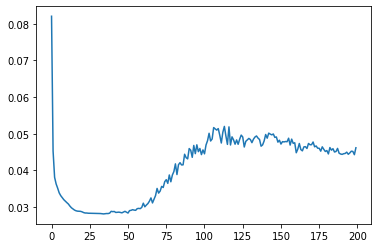

In [12]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(200):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

0.033771487084703275

In [14]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=10000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,10,self.T,1))
        xn=np.reshape(xn,(-1,10,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print(y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32),
                   'target':target[i*self.batchSize:(i+1)*self.batchSize].astype(np.float32)}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(10,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(10,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

IndexPrice shape:  (10000, 1)
StockPrice shape:  (10000, 27)
making dataset progress : finished	0
result =  Tensor("concat:0", shape=(None, 32, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f04d81583d0>
Y_2 =  (None, 32, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f063015e350>, <gast.gast.Return object at 0x7f063015e3d0>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f063015e350>, <gast.gast.Return object at 0x7f063015e3d0>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 32, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 32), dtype=float32)
e

9.94151141308248
4.136813662946224
epoch : 21, t_cost : 0.027089, e_cost : 0.026349, elapsed time : 129.92sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
9.906509284861386
4.15029301866889
epoch : 22, t_cost : 0.026993, e_cost : 0.026435, elapsed time : 129.97sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
9.909781407564878
4.15391986258328
epoch : 23, t_cost : 0.027002, e_cost : 0.026458, elapsed time : 129.88sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
9.905087416060269
4.147635553963482
epoch : 24, t_cost : 0.026989, e_cost : 0.026418, elapsed time : 129.90sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1

9.580411851406097
4.7056211065500975
epoch : 51, t_cost : 0.026105, e_cost : 0.029972, elapsed time : 129.86sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
9.504837016575038
4.428674974478781
epoch : 52, t_cost : 0.025899, e_cost : 0.028208, elapsed time : 129.91sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
9.423485829494894
4.491871004924178
epoch : 53, t_cost : 0.025677, e_cost : 0.028611, elapsed time : 129.89sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
9.377602373249829
4.311055165715516
epoch : 54, t_cost : 0.025552, e_cost : 0.027459, elapsed time : 129.92sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 3

6.414738226216286
6.892022220417857
epoch : 81, t_cost : 0.017479, e_cost : 0.043898, elapsed time : 129.90sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
6.268524782266468
9.524073775857687
epoch : 82, t_cost : 0.017080, e_cost : 0.060663, elapsed time : 129.93sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
5.893620447255671
8.495695106685162
epoch : 83, t_cost : 0.016059, e_cost : 0.054113, elapsed time : 129.94sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
7.139265026897192
7.908689726144075
epoch : 84, t_cost : 0.019453, e_cost : 0.050374, elapsed time : 129.93sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32

2.9210009332746267
7.54679905436933
epoch : 111, t_cost : 0.007959, e_cost : 0.048069, elapsed time : 129.98sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
2.82455065776594
7.509193507954478
epoch : 112, t_cost : 0.007696, e_cost : 0.047829, elapsed time : 129.99sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
2.806388583732769
7.226768271997571
epoch : 113, t_cost : 0.007647, e_cost : 0.046030, elapsed time : 129.89sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
2.851059759967029
7.292248593643308
epoch : 114, t_cost : 0.007769, e_cost : 0.046447, elapsed time : 129.91sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055,

1.7257831775350496
7.025738788768649
epoch : 141, t_cost : 0.004702, e_cost : 0.044750, elapsed time : 129.91sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
1.9789521843194962
7.002538965083659
epoch : 142, t_cost : 0.005392, e_cost : 0.044602, elapsed time : 130.00sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
1.62676357163582
7.138156378641725
epoch : 143, t_cost : 0.004433, e_cost : 0.045466, elapsed time : 129.89sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
1.5968066583154723
7.024073926731944
epoch : 144, t_cost : 0.004351, e_cost : 0.044739, elapsed time : 129.92sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (1880

1.1004021558328532
6.73602969199419
epoch : 171, t_cost : 0.002998, e_cost : 0.042905, elapsed time : 129.91sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
1.221567626693286
6.820397293195128
epoch : 172, t_cost : 0.003329, e_cost : 0.043442, elapsed time : 129.93sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
1.260430087626446
6.663727527484298
epoch : 173, t_cost : 0.003434, e_cost : 0.042444, elapsed time : 129.96sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (188055, 32, 1) (188055, 1)
(80595, 32, 1) (80595, 10, 32, 1) (80595, 10, 32, 1) (80595, 32, 1) (80595, 1)
1.4543205925729126
6.797433987259865
epoch : 174, t_cost : 0.003963, e_cost : 0.043296, elapsed time : 129.90sec
(188055, 32, 1) (188055, 10, 32, 1) (188055, 10, 32, 1) (18805

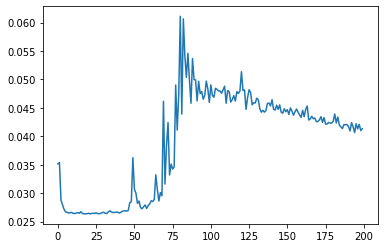

In [15]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(200):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (10000, 1)
StockPrice shape:  (10000, 27)
making dataset progress : finished	0
result =  Tensor("concat:0", shape=(None, 16, 256), dtype=float32)
LSTM2 =  <__main__.MI_LSTMCell object at 0x7f02e5a68c10>
Y_2 =  (None, 16, 64)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f02ec9e1110>, <gast.gast.Return object at 0x7f02ec9e1190>]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: expected exactly one node node, found [<gast.gast.FunctionDef object at 0x7f02ec9e1110>, <gast.gast.Return object at 0x7f02ec9e1190>]
inputs :  Tensor("rnn_22/transpose_1:0", shape=(None, 16, 64), dtype=float32)
weight :  Tensor("attention_1/Squeeze:0", shape=(None, 16), dtype=float32)
e

9.927467921748757
4.251194717362523
epoch : 21, t_cost : 0.027050, e_cost : 0.027078, elapsed time : 63.79sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
9.898613126948476
4.254051920026541
epoch : 22, t_cost : 0.026972, e_cost : 0.027096, elapsed time : 63.82sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
9.886992725543678
4.21444374974817
epoch : 23, t_cost : 0.026940, e_cost : 0.026844, elapsed time : 64.85sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
9.862029160372913
4.220451844856143
epoch : 24, t_cost : 0.026872, e_cost : 0.026882, elapsed time : 64.43sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) 

(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
8.08066282235086
5.8144710958004
epoch : 52, t_cost : 0.022018, e_cost : 0.037035, elapsed time : 63.96sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
8.418931487947702
5.4403102565556765
epoch : 53, t_cost : 0.022940, e_cost : 0.034652, elapsed time : 63.98sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
8.026594353839755
5.522003872320056
epoch : 54, t_cost : 0.021871, e_cost : 0.035172, elapsed time : 63.98sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
7.901963405311108
5.

(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
4.175540214171633
6.809348326176405
epoch : 82, t_cost : 0.011377, e_cost : 0.043372, elapsed time : 63.93sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
4.574784748489037
5.939749444834888
epoch : 83, t_cost : 0.012465, e_cost : 0.037833, elapsed time : 64.05sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
5.002953939605504
6.615781834349036
epoch : 84, t_cost : 0.013632, e_cost : 0.042139, elapsed time : 63.98sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
4.029526245780289


(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
2.725948595791124
7.027914574369788
epoch : 112, t_cost : 0.007428, e_cost : 0.044764, elapsed time : 64.12sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
2.3136321282945573
7.169886717572808
epoch : 113, t_cost : 0.006304, e_cost : 0.045668, elapsed time : 64.23sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
2.083038989454508
7.167618006467819
epoch : 114, t_cost : 0.005676, e_cost : 0.045654, elapsed time : 64.63sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
2.156573486514

(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
1.2497667715651914
6.899455236271024
epoch : 142, t_cost : 0.003405, e_cost : 0.043946, elapsed time : 63.72sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
1.3573520898353308
6.982638383284211
epoch : 143, t_cost : 0.003699, e_cost : 0.044475, elapsed time : 63.87sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
1.3639895997475833
6.964789481833577
epoch : 144, t_cost : 0.003717, e_cost : 0.044362, elapsed time : 63.79sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
1.4457769220

(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
1.3306347395991907
7.14275249838829
epoch : 172, t_cost : 0.003626, e_cost : 0.045495, elapsed time : 63.86sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
1.2956651112763211
6.980464404448867
epoch : 173, t_cost : 0.003530, e_cost : 0.044462, elapsed time : 63.80sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
1.331567249901127
7.226659035310149
epoch : 174, t_cost : 0.003628, e_cost : 0.046030, elapsed time : 63.84sec
(188055, 16, 1) (188055, 10, 16, 1) (188055, 10, 16, 1) (188055, 16, 1) (188055, 1)
(80595, 16, 1) (80595, 10, 16, 1) (80595, 10, 16, 1) (80595, 16, 1) (80595, 1)
1.507081895193

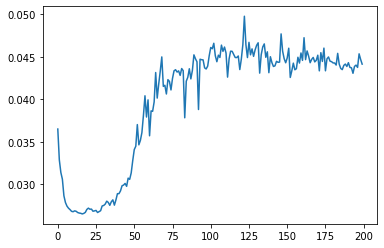

In [16]:
#tf.compat.v1.disable_eager_execution()
#tf.keras.backend.clear_session()
#tf.compat.v1.reset_default_graph()
#parameter list
'''
sess=tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True))
name='lstm'
timesize=20
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
'''
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512


kospi=StockData(
    'Energydata/sample',
    'Energydata/Appliances.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)



lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )


sess.run(tf.compat.v1.global_variables_initializer())
    

result_dic={}
evalution_costplt=[]    
for i in range(200):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0
    
    #training batch
    
    for batch in kospi.getBatch('training'):        
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print(training_cost)
    print(evalution_cost)
    
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
    i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))